# Preprocessing

Mounting to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Importing required packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pickle
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import TaggedDocument
from sklearn.model_selection import train_test_split
from google.colab import files
import datetime
import networkx as nx
import matplotlib.pyplot as plt
import random

In [ ]:
# Reading original data
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/lastfm-dataset-1K.tar/lastfm-dataset-1K/lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv',sep="\t", on_bad_lines='skip')
# Renaming the columns
data.columns =['userid', 'timestamp', 'artist_id', 'artist_name', 'track_id', 'track_name']
# Dropping rows where track id or track name is null
data['track_name'].isnull().values.any()
data=data.dropna(subset=['track_name'])

data['track_id'].isnull().values.any()
data=data.dropna(subset=['track_id'])
# resetting the index
data.reset_index(drop=True)

In [ ]:
# Convert object type to datetime object
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['timestamp'] = pd.to_datetime(data['timestamp'].dt.strftime("%Y-%m-%d %H:%M:%S.%f"))
print(data.dtypes)


Unnamed: 0              int64
userid                 object
timestamp      datetime64[ns]
artist_id              object
artist_name            object
track_id               object
track_name             object
dtype: object


In [ ]:
data.shape

(16936134, 7)

Creating Sessions

In [ ]:

# Sort the data by user and timestamp to ensure sequential order
data=data.groupby(['userid']).apply(lambda x: x.sort_values(['timestamp'], ascending=True)).reset_index(drop=True)

# Function to create unique session IDs based on time difference
def create_session_ids(data, threshold_time):
    session_ids = []
    prev_user = None
    prev_timestamp = None
    session_id_counter = 0

    for index, row in data.iterrows():
        user_id = row['userid']
        timestamp = pd.to_datetime(row['timestamp'])

        if prev_user is None or user_id != prev_user or (timestamp - prev_timestamp).total_seconds() > threshold_time:
            # Start a new session for a different user or if the time difference exceeds the threshold
            session_id_counter += 1

        session_ids.append(session_id_counter)

        prev_user = user_id
        prev_timestamp = timestamp

    return session_ids

# Set the threshold time in seconds (Here, 360 seconds = 6 minutes)
threshold_time_seconds = 360





In [ ]:
# Create unique session IDs based on the time difference
data['session_id'] = create_session_ids(data, threshold_time_seconds)

In [ ]:
data.to_csv('/content/drive/MyDrive/Colab Notebooks/Project/clean_data.csv',index=False)

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/clean_data.csv', on_bad_lines='skip',index_col=False)

Creating Tagged document

In [ ]:
def create_tagged_document(data):
    tagged_data = []
    words=[]
    session_id=1
    for idx, row in data.iterrows():
      if row['session_id'] == session_id:
        words.append(row['track_id'])
      else:
        tagged_data.append(TaggedDocument(words=words, tags=[str(session_id)]))
        words=[]
        words.append(row['track_id'])
        session_id=row['session_id']
    return tagged_data

tagged_data = create_tagged_document(data)

#Save the tagged document for future use
with open('/content/drive/MyDrive/Colab Notebooks/Project/tagged_documents.pkl', 'wb') as f:
    pickle.dump(tagged_data, f)



In [ ]:
# Split data into train and test sets
train_data, test_data = train_test_split(tagged_data, test_size=0.6, random_state=42)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Project/train_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)
with open('/content/drive/MyDrive/Colab Notebooks/Project/test_data.pkl', 'wb') as f:
    pickle.dump(test_data, f)


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Project/train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/Project/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [ ]:
# Split test into validation and test sets
val_data, testing_data = train_test_split(test_data, test_size=0.8, random_state=42)

Graph creation using song similarity

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Project/doc2vec_win_5_epoch_50.pkl', 'rb') as file:
    model1 = pickle.load(file)

In [ ]:
all_songs=[]
for tagged_data in train_data:
        songs = tagged_data.words
        for song in songs:
          all_songs.append(song)
unique_songs=list(set(all_songs))

print(len(unique_songs))

719509


In [ ]:
# Create a directed graph
G = nx.DiGraph()

# Function to add sessions as directed edges in the graph
def create_graph(graph, data):
    for song in unique_songs:
      try:
        simsongs=model1.wv.most_similar(song,topn=20)
        for song_id,sim_score in simsongs:
          if sim_score>=0.5:
            source_node = song
            target_node = song_id
            graph.add_edge(source_node, target_node,weight=sim_score)
      except KeyError:
        pass

# Add sessions to the graph
create_graph(G, train_data)


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Project/graph.pkl', 'wb') as f:
    pickle.dump(G, f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Project/graph.pkl', 'rb') as f:
    G = pickle.load(f)

Graph analysis

In [ ]:
if nx.is_weakly_connected(G):
  print("Yes graph is weakly connected")
else: print(nx.number_weakly_connected_components(G))

2


In [ ]:
weak_components=list(nx.weakly_connected_components(G))
component_sizes = [len(component) for component in weak_components]

print(component_sizes)


[240529, 24]


In [ ]:
#min(weak_components, key=len)
subgraph = G.subgraph(min(weak_components, key=len))
songid_song=[]
for i in list(subgraph.nodes()):
  song_name=data[data['track_id']==i]['track_name'].tolist()[0]
  songid_song.append((i,song_name))
d = dict(songid_song)
G_renamed = nx.relabel_nodes(subgraph, d)
subgraph_renamed = nx.relabel_nodes(subgraph, d)
# Plot the subgraph
pos = nx.spring_layout(subgraph_renamed, seed=42)  # For layout positioning
nx.draw(subgraph_renamed, pos, with_labels=True, node_size=30, node_color='yellow', font_size=7, font_color='gray',edge_color='gray',width=0.1,arrowsize=3)
plt.title("Smallest weak component Visualization")
plt.show()


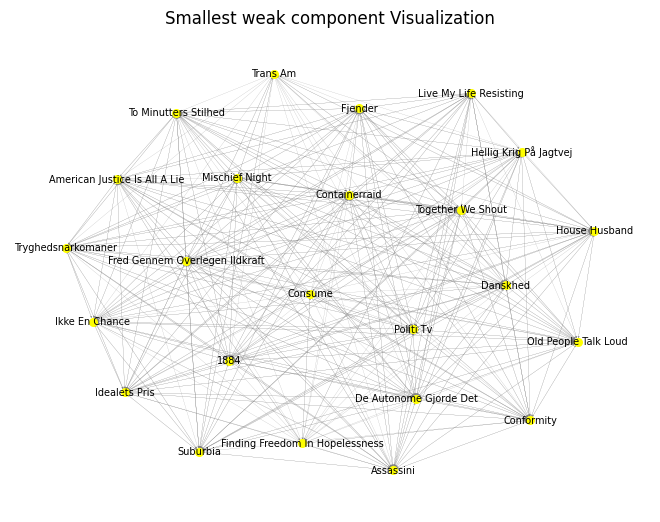

In [ ]:
# Plot the subgraph
pos = nx.spring_layout(subgraph_renamed, seed=42)  # For layout positioning
nx.draw(subgraph_renamed, pos, with_labels=True, node_size=30, node_color='yellow', font_size=7, font_color='black',edge_color='gray',width=0.1,arrowsize=3)
plt.title("Smallest weak component Visualization")
plt.show()

In [ ]:
if nx.is_strongly_connected(subgraph):
  print("Yes sub graph is strongly connected")
else: print(nx.number_strongly_connected_components(subgraph))

Yes graph is strongly connected


In [ ]:
# Create a subgraph for the largest weakly connected component
strong_components=list(nx.strongly_connected_components(G))
strong_components.remove(max(strong_components, key=len))
largest_strong_subgraph = G.subgraph(max(strong_components, key=len))

# Calculate the diameter of the largest weakly connected component
diameter = nx.diameter(largest_strong_subgraph)

print("Diameter of the Second Largest Strongly Connected Component:", diameter)


Diameter of the Largest Strongly Connected Component: 14


In [ ]:
diameter_nodes = []

for source_node in largest_strong_subgraph.nodes():
    distances = nx.shortest_path_length(largest_strong_subgraph, source=source_node)
    max_distance_node = max(distances, key=distances.get)
    if distances[max_distance_node] == diameter:
        diameter_nodes.append((source_node, max_distance_node))

print(f"Diameter of the graph: {diameter}")
print("Nodes contributing to the diameter:")
for source_node, max_distance_node in diameter_nodes:
    print(f"({source_node}, {max_distance_node})")
# Find the shortest path
shortest_path = nx.shortest_path(G, source=source_node, target=max_distance_node)

print(f"Shortest path between Node {source_node} and Node {max_distance_node}: {shortest_path}")

Diameter of the graph: 14
Nodes contributing to the diameter:
(409da0f6-2e1a-4d69-893a-cfa32a3152db, 8d728989-a857-4ea0-afd0-73affc18ec48)
Shortest path between Node 409da0f6-2e1a-4d69-893a-cfa32a3152db and Node 8d728989-a857-4ea0-afd0-73affc18ec48: ['409da0f6-2e1a-4d69-893a-cfa32a3152db', 'dbca08a3-0282-4231-8708-e5bbf79285c3', 'b15a4da2-2996-4331-9e24-5de019186c2a', 'ce595e65-d31d-4138-a206-5fb09f5db63d', 'b5eec268-e640-483b-9cf7-e855589b4d24', 'b912f44d-0431-4ea3-9ad5-b83b0da70b66', '7d298e10-2f0c-4e90-bad7-34154adc9f40', 'd4898a97-32ec-471c-ad77-a874ecf1f3e4', 'b18139c6-7bc4-4ce1-8b7a-f7936b318a2a', '6aaed1bf-5223-4ecd-98b5-f514195eb7c6', 'd264157f-ee1c-4dec-8b8a-6a8a5ac84d42', '16a55a36-a5d5-4a3a-acd7-7d0b85e9e539', 'e25c5afc-1383-4164-857b-9885b7acf694', '61d78bc9-a212-4299-87cb-00b1f85df12d', '8d728989-a857-4ea0-afd0-73affc18ec48']


In [ ]:
songname_songartist=[]
for i in shortest_path:
  song_name=data[data['track_id']==i]['track_name'].tolist()[0]
  artist_name=data[data['track_id']==i]['artist_name'].tolist()[0]
  songname_songartist.append((song_name,artist_name))
print(songname_songartist)

[('Der Picknicker', 'Die Fantastischen Vier'), ('S.M.U.D.O. Ich Bin Halt So', 'Die Fantastischen Vier'), ('Ganz Weit Weg', 'Die Fantastischen Vier'), ('Das Interview', 'Die Fantastischen Vier'), ('Dionysos', 'Fettes Brot'), ('Wer Gibt Dem Der Unten Liegt Die Hand', 'Fettes Brot'), ('Rocky Beach Theme', 'Fettes Brot'), ('Wie Immer', 'Fettes Brot'), ("Rock Mic'S", 'Fettes Brot'), ('No Answer', 'Falco'), ('Data De Groove', 'Falco'), ('Buenos Dias Messias (A Cappella)', 'Die Fantastischen Vier'), ('45 Fieber', 'Die Fantastischen Vier'), ('Geboren', 'Die Fantastischen Vier'), ('Mikrofonprofessor', 'Die Fantastischen Vier')]


In [ ]:
average_degree = sum(dict(G.degree()).values()) / len(G)

print(f"Average Degree: {average_degree:.2f}")

Average Degree: 39.83


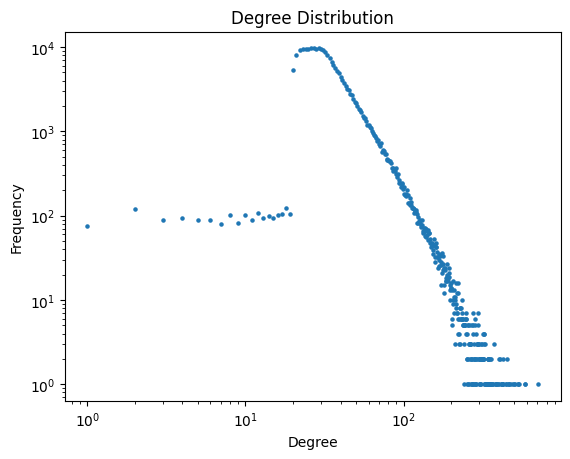

In [ ]:
degree_hist = nx.degree_histogram(G)

# Plot the degree distribution
plt.scatter(range(len(degree_hist)), degree_hist,s=5)
#plt.hist(degree_hist)

plt.xscale('log')
plt.xlabel("Degree")
plt.yscale('log')
plt.ylabel("Frequency")
plt.title("Degree Distribution")
plt.show()

Graph Creation using session based data


In [ ]:
# Create a directed graph
G1 = nx.DiGraph()

# Function to add sessions as directed edges in the graph
def add_sessions_to_graph(graph, data):
    for tagged_data in data:
        songs = tagged_data.words
        for i in range(len(songs) - 1):
            source_node = songs[i]
            target_node = songs[i + 1]
            if graph.has_edge(source_node, target_node):
              graph[source_node][target_node]['weight'] = graph[source_node][target_node]['weight'] + 1
            else:
              graph.add_edge(source_node, target_node,weight=1)

# Add sessions to the graph
add_sessions_to_graph(G1, train_data)



Graph analysis

If graph is weakly connected else Number of weakly connected components

In [ ]:
if nx.is_weakly_connected(G1):
  print("Yes graph is weakly connected")
else: print(nx.number_weakly_connected_components(G1))

12256


In [ ]:
average_degree = sum(dict(G1.degree()).values()) / len(G)

print(f"Average Degree: {average_degree:.2f}")

Average Degree: 16.13


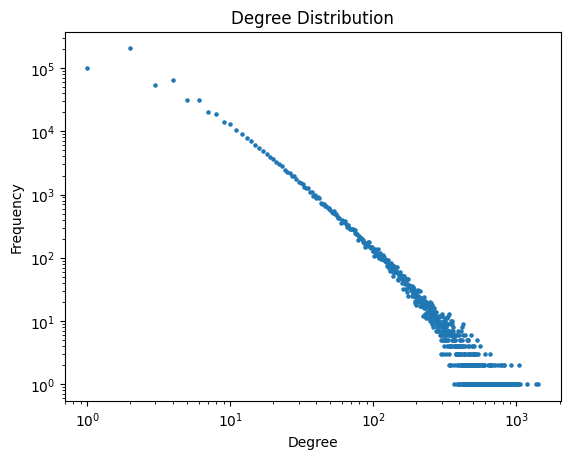

In [ ]:
degree_hist = nx.degree_histogram(G1)

# Plot the degree distribution
plt.scatter(range(len(degree_hist)), degree_hist,s=5)
#plt.hist(degree_hist)

plt.xscale('log')
plt.xlabel("Degree")
plt.yscale('log')
plt.ylabel("Frequency")
plt.title("Degree Distribution")
plt.show()

In [ ]:
weak_components=list(nx.weakly_connected_components(G))
component_sizes = [len(component) for component in weak_components]

# Plot the size distribution
plt.bar(range(len(component_sizes)),component_sizes )
plt.xlabel("Component Size")
plt.ylabel("Frequency")
plt.title("Weakly Connected Component Size Distribution")
#plt.xticks(range(1, max(component_sizes)+1))
plt.show()

In [ ]:
len(G1.nodes())

681850

In [ ]:
len(weak_components[0])

240529

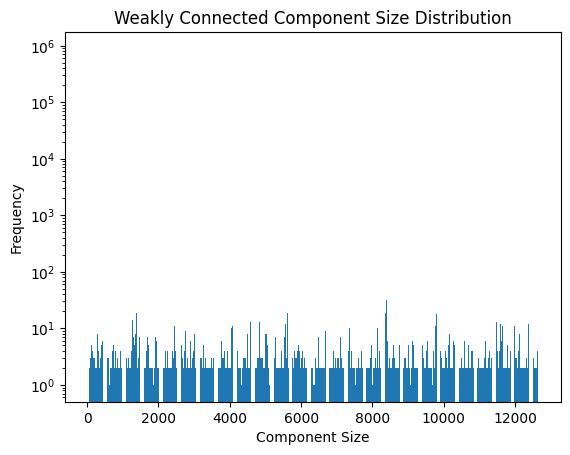

In [ ]:
weak_components=list(nx.weakly_connected_components(G))
component_sizes = [len(component) for component in weak_components]

# Plot the size distribution
plt.bar(range(len(component_sizes)),component_sizes,log=True )
plt.xlabel("Component Size")
plt.ylabel("Frequency")
plt.title("Weakly Connected Component Size Distribution")
#plt.xticks(range(1, max(component_sizes)+1))
plt.show()


In [ ]:
avg_cluster_coefficient = nx.average_clustering(G)

print(f"Average Clustering Coefficient: {avg_cluster_coefficient:.4f}")

Average Clustering Coefficient: 0.0211


In [ ]:
weak_components = list(nx.weakly_connected_components(G))
clu=[]
# Calculate and plot the average clustering coefficient for each component
for component in weak_components:
    subgraph = G.subgraph(component)
    avg_clustering = nx.average_clustering(subgraph)
    length_of_component=len(component)
    #print(f"Component: {component}, Average Clustering Coefficient: {avg_clustering:.4f}")
    clu.append((length_of_component,avg_clustering))


In [ ]:
def get_test_session(test_data,index):
  if len(test_data[index][0])<3:
    print("Choose some other test session as this one is too small to suggest next song.")
    return (0,0,0)
  else:
    next_song_id=test_data[index][0][-1]
    next_song=data[data['track_id']==next_song_id]['track_name'].tolist()[0]
    next_artist=data[data['track_id']==next_song_id]['artist_name'].tolist()[0]
    session=test_data[index][0][:-1]
    return session,next_song,next_artist


In [ ]:
def recommend_top_songs_graph(graph,session,personalization_factor,alpha,max_iter):

  if personalization_factor==0:
      ppr = nx.pagerank(graph,alpha=alpha,max_iter=max_iter)
  else:
    try:
      personalization=dict.fromkeys(G.nodes(),0)
      mytuple=(personalization_factor/len(session))
      res=((mytuple,)*len(session))
      personalization.update(dict(zip(session, res)))
      ppr = nx.pagerank(graph,personalization=personalization,alpha=alpha,max_iter=max_iter,weight='weight')
    except ZeroDivisionError:
      ppr = nx.pagerank(graph,alpha=alpha,max_iter=max_iter)
      pass
    sorted_nodes = sorted(ppr.items(), key=lambda x: x[1], reverse=True)
    top_n=10
    recommend_songs = [data[data['track_id']==node]['track_name'].tolist()[0] for node, score in sorted_nodes[:top_n]]
    recommend_artist = [data[data['track_id']==node]['artist_name'].tolist()[0] for node, score in sorted_nodes[:top_n]]
    score=[score for node, score in sorted_nodes[:top_n]]
  return recommend_songs,recommend_artist



def hit_rate_graph(test_data,pf=1,alpha=0.85,max_iter=50):
    total_sessions = len(test_data)
    correct_recommendations = 0
    actual_total_sessions=0
    for i in range(0,total_sessions):
      session,actual_next_song,actual_next_artist=get_test_session(test_data,i)
      if (session,actual_next_song,actual_next_artist)==(0,0,0):
        continue
      else:
        recommended_songs,recommended_artist = recommend_top_songs_graph(G,session,pf,alpha,max_iter)
        if recommended_songs==[]:
          print("Page rank did not recommend songs for the given sequence.")
        else:
          actual_total_sessions=actual_total_sessions+1
          print("recommended songs",recommended_songs)
          print("actual song",actual_next_song)
          print("recommended artists",recommended_artist)
          print("actual artist",actual_next_artist)
          if actual_next_song in recommended_songs:
            correct_recommendations += 1
          elif actual_next_artist in recommended_artist:
            correct_recommendations += 0.5


    hit_rate = correct_recommendations / actual_total_sessions
    print(actual_total_sessions)
    return hit_rate

In [ ]:
def MRR_graph(test_data,pf=1,alpha=0.85,max_iter=50):
    total_sessions = len(test_data)
    sum_reciprocal_rank = 0
    actual_total_sessions=0
    for i in range(0,total_sessions):
      session,actual_next_song,actual_next_artist=get_test_session(test_data,i)
      if (session,actual_next_song,actual_next_artist)==(0,0,0):
        continue
      else:
        actual_total_sessions=actual_total_sessions+1
        recommended_songs,recommended_artist = recommend_top_songs_graph(G,session,pf,alpha,max_iter)
        print("recommended songs",recommended_songs)
        print("actual song",actual_next_song)
        print("recommended artists",recommended_artist)
        print("actual artist",actual_next_artist)
        if actual_next_song in recommended_songs:
          rank = recommended_songs.index(actual_next_song)+1 #because we start from 0 index
          print(rank)
          sum_reciprocal_rank += 1.0/rank
          print(sum_reciprocal_rank)


    mrr = sum_reciprocal_rank / actual_total_sessions
    print(actual_total_sessions)
    return mrr

In [ ]:
hit_rate_graph(val_data[:21],pf=0)

In [ ]:
hit_rate_graph(val_data[:21],pf=1)

In [ ]:
hit_rate_graph(val_data[:21],pf=1,alpha=0.3)

In [ ]:
hit_rate_graph(val_data[:21],pf=1,alpha=1)

Final Testing

In [ ]:
hit_rate_graph(testing_data[:150])

In [ ]:
MRR_graph(testing_data[:150])

In [ ]:
hit_rate_graph(testing_data[:150])

In [ ]:
MRR_graph(testing_data[:150])